# Construcción de Técnicas de Normalización para Datos en Histograma time residual  vs cos(α)

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
file = uproot.open("/snoplus simulations/electron bulk/random point/random dir/Low Statistic/simu_Analysis_elec_10MeV.root")
file.keys()

['T;6', 'T;5', 'pmt;2', 'pmt;1']

In [4]:
data1 = file['T;6']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [5]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [6]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
mc_position = np.array(data1['mc_position'])  # -> Position Generation
mc_momentum = np.array(data1['mc_momentum'])  # -> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

In [7]:
mc_momentum[0]

array([-7.77130651, -1.45431697,  6.90736818])

## 1.2 - PMT info

In [8]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

In [9]:
pmt_pos_xyz

array([[-9.99990e+04, -9.99990e+04, -9.99990e+04],
       [ 5.46754e+03,  6.34400e+01, -6.40627e+03],
       [ 5.61516e+03,  2.66800e+02, -6.25109e+03],
       ...,
       [ 4.97000e+02, -5.57700e+03,  7.30100e+03],
       [ 3.96400e+03, -4.70800e+03,  6.84000e+03],
       [ 2.03200e+03, -2.09800e+03,  8.72900e+03]])

# 2 - Extract Valid Data

## 2.1 - Extract  valid PMT id

In [10]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([       0,        1,        2, ..., 11158432, 11158433, 11158434],
      dtype=int64)

### 2.1.1 - Extraer información valida de PMT info

In [11]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

### 2.1.2 - Encontrar el nº de PMTs disponibles dentro de cada intervalo de cos(α) en todo el Detector

1. Transformar datos por una translación (sumar a cada coordenada de PMT el vector vertex de MC y reconstruido)
2. Calcular cos(α) para todos los PMTs
3. Dividir α en subsecciones (corresponder al binning del histograma). Usaremos el cos(α). α variar entre [0,π], y cos(α) entre [-1,1]
4. Contabilizar el nº de PMTs dentro de está sección y guardar esta información -> Nº de PMTs = Nº de datos en cos(Δα)

In [133]:
#Compute cos(angle)
vec_ev = mc_momentum[0]
cos_angle = []

#Deslocation of PSUP by a vector equal to the mc_vertex
#for example:
T_vector = mc_position[0]
T_pmt_xyz = valid_pmt_xyz + T_vector

N = np.shape(valid_pmt_xyz)[0] 
for i in range(N):
    scalar_product = np.dot(T_pmt_xyz[i],vec_ev)
    norm_1 = np.linalg.norm(T_pmt_xyz[i])
    norm_2 = np.linalg.norm(vec_ev)
    cos_val = scalar_product/(norm_1*norm_2)
    cos_angle.append(cos_val)
cos_angle = np.array(cos_angle)
cos_angle

array([-0.98445576, -0.98553305, -0.98579542, ..., -0.62689144,
       -0.58241994, -0.61186463])

### 2.1.3 - Gráfico de Distribuición de PMTs

Este gráfico muestra como los se observa la Distribución de PMTs cuando salimos del centro del Detector

In [134]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Now devide the cos_angel in sections, lets use an Histogram and then extract the counts per bin
bins = 40

title = 'Nº of PMT in cos(Δα) section'
ytitle = 'PMT counts'
xtitle = 'cos(α)'

aval_PMT, x_, y_ = plt.hist(cos_angle, bins = bins, edgecolor='black', facecolor='g')
plt.ylabel(ytitle)
plt.xlabel(xtitle)
plt.title(title)
plt.show()

aval_PMT = aval_PMT.astype(int)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [25]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 5
#time cut
inf_cut = -5
up_cut = 15

#radia cut
radi_cut_method = True   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 3500.0
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
multi_position_cut = []
multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        
        scalar_product = np.dot(multi_xyz_hit[k], multi_mc_momentum[k])
        norm_1 = np.linalg.norm(multi_mc_momentum[k])
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        multi_position_cut.append(multi_position[i])
        multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
multi_position_cut = np.array(multi_position_cut)
multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
In radi_cut, split nº:  0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In radi_cut, split nº:  1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In radi_cut, split nº:  2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In radi_cut, split nº:  3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In radi_cut, split nº:  4
computing cos(alpha)
doing time residual cuts


# 3 - Histograma 2D: time residual vs. cos(α)

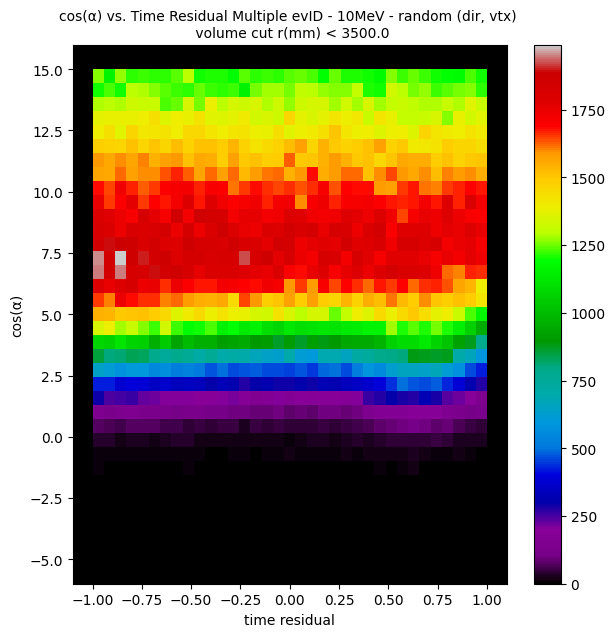

In [26]:
#%matplotlib
# 2d Histogram
bins = 35
#Titles

if radi_cut_method == True:
    title = 'cos(α) vs. Time Residual Multiple evID - 10MeV - random (dir, vtx) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'cos(α) vs. time residual - Multiple evID - 10MeV - random (dir,vtx)'
    
ylabel = 'cos(α)'
xlabel = 'time residual'

#bins defined above when computing the Nº of PMTs in each Δα!

plt.figure(figsize=(7,7))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins], stat='count', cbar = 'True', cmap = cm.nipy_spectral, hue_norm = (0,1))
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize= 10)
plt.savefig('figs/Low Stat/cos(α) vs. time residual - Multiple evID - 10MeV_' + str(rad_cut_val) + '_' + str(bins) + '.png', format = 'png')
#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

# 3 - Construcción Histograma Normalizados 


## 3.1 - Extraer Información a Normalizar

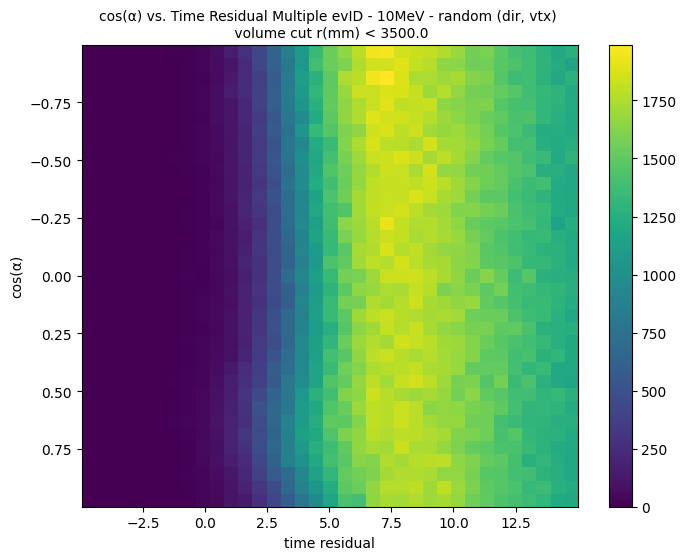

In [27]:
#Transforma Data into an Image Matrix
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

plt.figure(figsize=(8,6))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
plt.savefig('figs/Low Stat/cos(α) vs. time residual - Multiple evID - 10MeV_' + str(rad_cut_val) + '_' + str(bins) + '(imshow).png', format = 'png')

### 3.2 - Metodo 1: Dividir por el Nº de PMTs que dan hit en cada bin de cos(α)

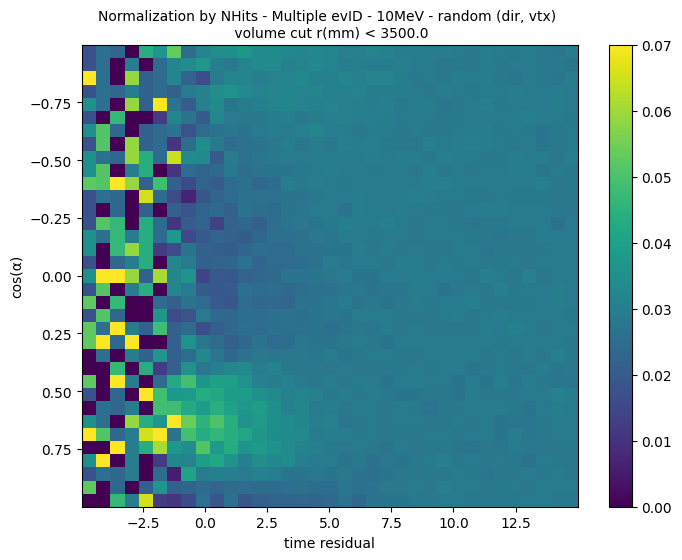

In [28]:
# sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_normalized1 = H / sum_hit

if radi_cut_method == True:
    N1title = 'Normalization by NHits - Multiple evID - 10MeV - random (dir, vtx) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    N1title = 'Normalization by NHits - Multiple evID - 10MeV - random (dir, vtx)'

plt.figure(figsize=(8,6))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto", vmin = 0.0, vmax = 0.07)
plt.title(N1title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
plt.savefig('figs/Low Stat/Normalization by NHits - Multiple evID - 10MeV_' + str(rad_cut_val) + '_' + str(bins) + '(imshow).png', format = 'png')

### 3.3 - Metodo 2: Dividir por el Nº de PMTs disponibles en cada bin de cos(α)

In [79]:
H_normalized2 = H / aval_PMT

if radi_cut_method == True:
    
    N2title = 'Normalization by Nº PMTs in cos(α) section - Multiple evID - 10MeV - random (dir, vtx) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    N2title = 'Normalization by Nº PMTs in cos(α) section - Multiple evID - 10MeV - random (dir, vtx)'

plt.figure(figsize=(10,8))
plt.imshow(H_normalized2, extent = [left, right, top, bottom], aspect="auto" )
plt.title(N2title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()

## 3.4 - Metodo Random Vertex

En este metodo cada evento debera ser normalizado por el denominador $N_{Hits}(cosα)/N_{PMT}(cosα)$. Será necesario extraer la distribución de PMTs en el detector dado el vertice del evento y extraer los hits dentro de cada cos(Δα) para asi obterner la normalizacion deseada

### 3.4.1 - Extraer Datos

Es necesario extraer datos de evento a eventos de modo a contabilizar la distribucion de PMTs dados. 1) vertex fuera de centro; 2) direccion del evento

#### - Encontrar indices donde mcID cambia de número

In [17]:
break_i = [0] #List of indices where data change of event ID

N_evts = len(multi_mc_ID_cut)
for i in range(N_evts-1):
    if multi_mc_ID_cut[i] != multi_mc_ID_cut[i+1]:
        break_i.append(i+1)    
break_i = np.array(break_i, dtype = np.int32)

In [18]:
break_i

array([      0,    1185,    2274, ..., 4455047, 4456309, 4456315])

In [133]:
multi_mc_ID_cut[break_i[0]]

0

In [24]:
len(multi_time_residual_cut[break_i[4]:break_i[5]])

1227

#### - Prueba de que break_i consige separar eventos

In [118]:
i_i = 0
i_f = 1

time_residual_ev = multi_time_residual_cut[break_i[i_i]:break_i[i_f]]
cos_angle_ev = multi_cos_angle_cut[break_i[i_i]:break_i[i_f]]
H_ev, _, _ = np.histogram2d(x = cos_angle_ev, y = time_residual_ev, bins = [bins, bins])
plt.imshow(H_ev)
plt.colorbar()

In [117]:
np.shape(H_ev)

(35, 35)

In [118]:
sum_hit = np.sum(H_ev, axis=0)
sum_hit

array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  5.,  9., 12., 14., 18., 21.,
       28., 34., 49., 61., 61., 50., 55., 68., 50., 48., 73., 59., 49.,
       56., 52., 46., 58., 42., 38., 45., 35., 46.])

In [76]:
plt.imshow(H_ev/sum_hit)

C:\Users\maria\AppData\Local\Temp\ipykernel_3396\732428593.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_ev/sum_hit)


In [147]:
mc_momentum_ev = multi_mc_momentum_cut[break_i[1]]
position_ev = multi_position_cut[break_i[1]]

pmt_cos_angle = []
T_pmt_xyz = valid_pmt_xyz + position_ev   #Translation transformation of PMT info data
N = np.shape(valid_pmt_xyz)[0]
for i in range(N):
    scalar_product = np.dot(T_pmt_xyz[i], mc_momentum_ev)
    norm_1 = np.linalg.norm(T_pmt_xyz[i])
    norm_2 = np.linalg.norm(mc_momentum_ev)
    cos_val = scalar_product/(norm_1*norm_2)
    pmt_cos_angle.append(cos_val)
pmt_cos_angle = np.array(pmt_cos_angle, dtype = np.float32)
N_pmt, _ = np.histogram(pmt_cos_angle, bins = bins)

In [148]:
norm_factor = sum_hit/N_pmt
H_norm = H_ev/norm_factor

C:\Users\maria\AppData\Local\Temp\ipykernel_14212\1096159362.py:2: RuntimeWarning: invalid value encountered in divide
  H_norm = H_ev/norm_factor


In [150]:
plt.imshow(H_norm)

#### - Extraer los datos que corren entre los elementos de break_i y construir normalización

Estrategia de corte de calidad:

- cortar eventos con pocos puntos: Tomemos N_ev, si len(time_residual) < 1000 Datos -> Pass
- obligar outliers de pico alto a ser cero: implementación -> comparar con los maximos de histogramas regulares, y si algun histograma tiene un punto que exceda un limite regular de counts, entonces convertir este elemento de matriz en cero

In [19]:
N_breaks = len(break_i)
bins = 35
H3_i = [] # Will save all the images, event by event. To get the superpostion of images we just have to sum all images in H3
H3_all = np.zeros((bins,bins))  #All superpostions
norm_factor_ctrl = []
for i_dx in range(1, N_breaks):

    #Data to be used in each mcID value
    init_i = break_i[i_dx-1]
    final_i = break_i[i_dx]
    
    time_residual_ev = multi_time_residual_cut[init_i:final_i]
    cos_angle_ev = multi_cos_angle_cut[init_i:final_i]
    mc_momentum_ev = multi_mc_momentum_cut[init_i]
    position_ev = multi_position_cut[init_i]

    #Nº of events control: There are events with an incoherent number of events - cut them.
    N_ev = len(time_residual_ev)
    if N_ev < 1000:
        continue

    #Use each Data to construct Histograms:
    #1) event Histogram and counts
    H_ev, _, _ = np.histogram2d(x = cos_angle_ev, y = time_residual_ev, bins = [bins, bins])
    sum_hit = np.sum(H_ev, axis=0) 

    #2) Use the postion and mc_momentum to obtain the PMT distribution
    pmt_cos_angle = []    # angle of PMTs relative to the mc_momentum_ev
    T_pmt_xyz = valid_pmt_xyz + position_ev   #Translation transformation of PMT info data
    N = np.shape(valid_pmt_xyz)[0]
    for i in range(N):
        scalar_product = np.dot(T_pmt_xyz[i], mc_momentum_ev)
        norm_1 = np.linalg.norm(T_pmt_xyz[i])
        norm_2 = np.linalg.norm(mc_momentum_ev)
        cos_val = scalar_product/(norm_1*norm_2)
        pmt_cos_angle.append(cos_val)
    pmt_cos_angle = np.array(pmt_cos_angle, dtype = np.float32)
    N_pmt, _ = np.histogram(pmt_cos_angle, bins = bins)

    norm_factor = (sum_hit / N_pmt)
    norm_factor_ctrl.append(norm_factor)

    norm_data = H_ev/norm_factor
    norm_data = np.nan_to_num(norm_data, nan = 0.0)

    H3_i.append(norm_data)
    H3_all += norm_data

#Avoid under/oveflow bins:

row_f = np.shape(H3_all)[0]    #selection of cut on rows
column_f = np.shape(H3_all)[1] #selection of cut on cloumns

H3_del1 = np.delete(H3_all,[0,row_f-1], 0) #del extremal row
H3_del2 = np.delete(H3_all,[0,column_f-1], 1) #del extremal column
H3_all_del = H3_del2

C:\Users\joanc\AppData\Local\Temp\ipykernel_18704\3029285759.py:43: RuntimeWarning: invalid value encountered in divide
  norm_data = H_ev/norm_factor


#### - See Plots

In [20]:
plt.imshow(H3_i[9], extent = [left, right, top, bottom], aspect="auto")#, vmin = 0, vmax = 350) #One event image
plt.ylabel(ylabel)
plt.xlabel(xlabel) 
plt.colorbar()
#plt.savefig('figs/Low Stat/uni_event4_NormNhit_div_Npmt.png', format = 'png')

In [163]:
H3_all

array([[14322.        ,  6017.48333333,  7311.975     , ...,
         6548.72682163,  6701.54786362,  7069.63119928],
       [10556.1       ,  7025.32261905,  8564.40833333, ...,
         6379.3176706 ,  6323.11915455,  6153.24691009],
       [ 9133.73809524,  4369.40833333,  6420.2702381 , ...,
         6544.33460079,  6340.88751008,  6661.49320828],
       ...,
       [ 4178.40952381,  2608.61904762,  2934.22380952, ...,
         8544.55809707,  7757.41521359,  7525.90371697],
       [ 4356.11666667,  2084.96111111,  2081.95757576, ...,
         8337.79473564,  8556.16211356,  8224.05961825],
       [ 4827.86666667,  1985.16349206,  3103.76071429, ...,
         8322.77021604,  7963.7575635 ,  8704.37505953]])

In [142]:
plt.imshow(H3_all) #All event image
plt.colorbar()

In [27]:
multi_time_residual_cut[len(multi_time_residual_cut)-1]

6.745175598562952

In [22]:
data_size = len(multi_time_residual_cut)

left_del = np.min(multi_time_residual_cut[1:data_size-2])
right_del = np.max(multi_time_residual_cut[1:data_size-2])
bottom_del = np.min(multi_cos_angle_cut[1:data_size-2])
top_del = np.max(multi_cos_angle_cut[1:data_size-2])

if radi_cut_method == True: 
    title = 'Norm by Nhits/Npmt - Multiple evID - 10MeV - r(mm) < '+str(rad_cut_val)
    filename = 'norm NHits_Npmt_10MeV_' + str(rad_cut_val) + 'mm_' + str(bins)

else:
    title = 'Norm by Nhits/Npmt - Multiple evID - 10MeV'
    filename = 'norm NHits_Npmt_10MeV_' + str(bins)


plt.imshow(H3_all_del, extent = [left_del, right_del, top_del, bottom_del], aspect="auto") #All event image
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize = 10)
plt.colorbar()
#plt.savefig('figs/low Stat/'+filename+'.png', format = 'png')

In [120]:
H3_i_norm_test = np.array(H_ev/norm_factor_ctrl[0], dtype = np.float32)
H3_i_norm_test = np.nan_to_num(H3_i_norm_test, nan = 0.0)

C:\Users\maria\AppData\Local\Temp\ipykernel_3396\945866111.py:1: RuntimeWarning: invalid value encountered in divide
  H3_i_norm_test = np.array(H_ev/norm_factor_ctrl[0], dtype = np.float32)


# 4 - Analisis de Sistematicos

Comparación entre mc_position y recons_position (más información en notebook Volume Cut Analysis)

In [35]:
#Load normalized data using mc_position, and recons_postion
H_normalized_mc = np.genfromtxt('norm_observable_info-mc_position-5500.0_60.csv', delimiter=',')
H_normalized_recons = np.genfromtxt('norm_observable_info-recons_position-5500.0_60.csv', delimiter=',')

In [36]:
H_ratio = (H_normalized_mc+1)/(H_normalized_recons+1)  #sumamos +1 para evitar divisiones por 0
ratio = np.ravel(H_ratio)  #Flatten values of ratio between counts

## 4.1 - Rescale valores de 2Dhist(cos(α), time_res) normalizado por NHits en el rango de la variable Ratio

In [55]:
from sklearn.preprocessing import MinMaxScaler

min_val = np.min(ratio)
max_val = np.max(ratio)

scaler = MinMaxScaler((min_val, max_val))
scaler.fit(H_normalized1)
sys_scale_H = scaler.transform(H_normalized1)

#PLOT------------

if radi_cut_method == True:
    N1title = 'Rescaling by Ratio = (mc_pos/recons_pos) - Norm NHits - Multiple evID - 10MeV \n random (dir, vtx) volume cut r(mm) < '+str(rad_cut_val)

else:
    N1title = 'Rescaling by Ratio - Norm NHits(mc_pos/recons_pos) - Multiple evID - 10MeV \n random (dir, vtx)'
    
plt.figure(figsize=(10,8))
plt.imshow(sys_scale_H, extent = [left, right, top, bottom], aspect="auto" )
plt.title(N1title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/Low Stat/Rescaling by Ratio Norm NHits 10MeV random (dir, vtx) '+str(rad_cut_val)+'_'+str(bins)+'.png', format='png')